In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Union, Callable, Tuple, Any
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Proxy income

As previously chapter, the income feature is a crucial consideration in the loan underwriting process. In this chapter, we will explore the way to create a proxy income model. However, it may not be entirely accurate which makes it's difficult to use in real practice. Taking the uncertainty into account can help mitigating the risk when making the decision.

In [2]:
df = pd.read_csv("../data/00_enriched_data.csv")
df.head()
df.shape

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,TotalIncomeBin,ApplicantIncomeBin,MonthlyPayment,TotalPay,ExpectedProfit
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1,5849.0,"(5000, 9000]","(3500, 6000]",NaN,NaN,NaN
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0,"(5000, 9000]","(3500, 6000]",767.424672,276272.881990,148272.881990
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0,<= 3500,"(2500, 3500]",395.703347,142453.204776,76453.204776
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0,"(3500, 5000]","(2500, 3500]",719.460630,259005.826866,139005.826866
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0,"(5000, 9000]","(3500, 6000]",845.366240,304331.846568,163331.846568


(614, 19)

In [3]:
df_copy = df.dropna().copy()

## Baseline point-esitmation

In this section, we examine the various Machine Learning algorithms.

In [4]:
from sklearn.model_selection import train_test_split

from modeling import encode_categorical_features, encode_categorical_features_v2, encode_all, apply_encoders, rollout_result, encode_numerical_features, safe_df

In [5]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [6]:
train, test = train_test_split(df_copy, test_size=0.2, random_state=123)
train, val = train_test_split(train, test_size=0.2, random_state=123)

train.shape, val.shape, test.shape

((307, 19), (77, 19), (96, 19))

In [7]:
train_encoded, encoder = encode_all(
    df=train, 
    cat_encoder_fn=encode_categorical_features, 
    num_encoder_fn=encode_numerical_features,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncome"
)

val_encoded = apply_encoders(
    df=val,
    encoder=encoder,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncome"
)

test_encoded = apply_encoders(
    df=test,
    encoder=encoder,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncome"
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [8]:
models = [
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    LinearRegression(),
    XGBRegressor()
]

In [9]:
for model in models:
    _ = model.fit(
        train_encoded.drop("ApplicantIncome", axis=1), 
        train_encoded["ApplicantIncome"]
    )

MAPE RandomForestRegressor: 0.8520397696654793
MAPE GradientBoostingRegressor: 0.9092260217375859
MAPE LinearRegression: 0.854051928774822
MAPE XGBRegressor: 0.8507925548534278


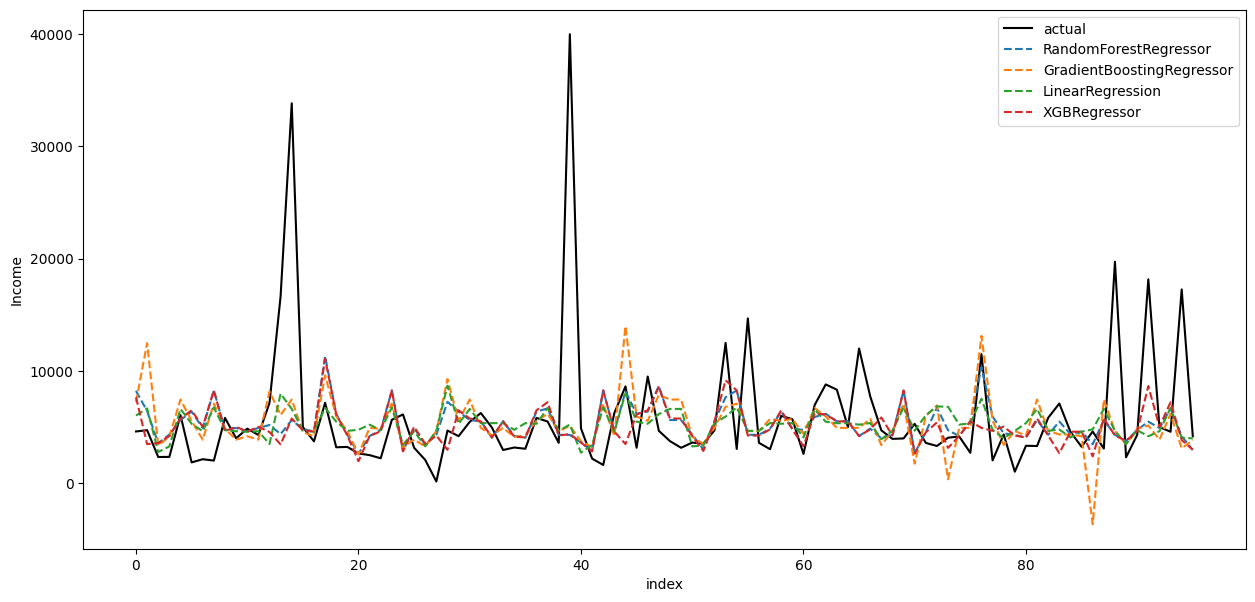

In [10]:
fig, ax = plt.subplots(figsize=(15, 7), ncols=1)

_ = ax.plot(test_encoded["ApplicantIncome"], c="black", label="actual")

for model in models:
    model_name = model.__class__.__name__
    pred = model.predict(test_encoded.drop("ApplicantIncome", axis=1))
    
    _ = ax.plot(pred, "--", label=model_name)
    print(f"MAPE {model_name}: {mean_absolute_percentage_error(test_encoded['ApplicantIncome'], pred)}")

_ = ax.set_ylabel("Income")
_ = ax.set_xlabel("index")
_ = plt.legend()

`XGBRegressor` model performs the best in the pool of models. However, with a MAPE error rate of over 80%, the model may not be practical for direct use in a real-world scenario. It would be wise instead of considering only the prediction point, but also take the uncertainty of the model into account and make the decision based on the level of uncertainty. i.e., set a higher interest rate for the high uncertainty borrowers in order to compensate for the potential risk. This way, even if the prediction of the borrower's income turns out to be incorrect, the bank will still be protected.

Later, we will explore how to quantify the uncertainty of the model.

## Quantile regression

Quantile regression is extension of linear regression which allows to estimate the $k^{th}$ percentile of the prediction.

![](../images/normal_distribution.png)

Generally, point-estimation algorithms such as linear regression do not take the variance of the predicition into account only aiming to estimate $\mu$. Quantile regression offers a way to esitmate $k^{th}$ percentile of the prediction without modeling $\sigma$. Once we are able to estimate the lower and upper bound of the prediction (let's say $5^{th}, 95^{th}$), we can interprete the range of the bound as a measure of uncertainty. 

In [11]:
from sklearn.linear_model import QuantileRegressor
from sklearn.ensemble import GradientBoostingRegressor

from q_regression_nn import QuantileNN


common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=9,
    min_samples_split=9,
)


class VanillaQuantileRegression:
    def __init__(self, q: List[float] = [0.05, 0.5, 0.95], mode: int = 1):
        self.q_levels = q
        self.mode = mode
        self.models = {}
        
    def fit(self, X, y):
        for q in self.q_levels:
            if self.mode == 1:
                self.models[q] = QuantileRegressor(quantile=q)
            elif self.mode == 2:
                self.models[q] = GradientBoostingRegressor(loss="quantile", alpha=q, **common_params, random_state=123)
            self.models[q].fit(X, y)

    def predict(self, X, median=True) -> np.ndarray:
        preds = []
        for q in self.q_levels:
            pred = self.models[q].predict(X)
            preds.append(pred.reshape((-1, 1)))
        preds = np.concatenate(preds, axis=1)
        return preds[:, 1] if median else preds

In [12]:
model1 = VanillaQuantileRegression()
_ = model1.fit(
    train_encoded.drop("ApplicantIncome", axis=1), 
    train_encoded["ApplicantIncome"]
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:295: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 4: Numerical difficulties encountered.
Result message of linprog:
The solution do

In [13]:
model2 = VanillaQuantileRegression(mode=2)
_ = model2.fit(
    train_encoded.drop("ApplicantIncome", axis=1), 
    train_encoded["ApplicantIncome"]
)

In [14]:
model3 = QuantileNN(123, train_encoded.shape[1] - 1)
_ = model3.fit(
    train_encoded.drop("ApplicantIncome", axis=1), 
    train_encoded["ApplicantIncome"]
)

In [15]:
pred1 = model1.predict(test_encoded.drop("ApplicantIncome", axis=1), False)
pred2 = model2.predict(test_encoded.drop("ApplicantIncome", axis=1), False)
pred3 = model3.predict(test_encoded.drop("ApplicantIncome", axis=1), False)

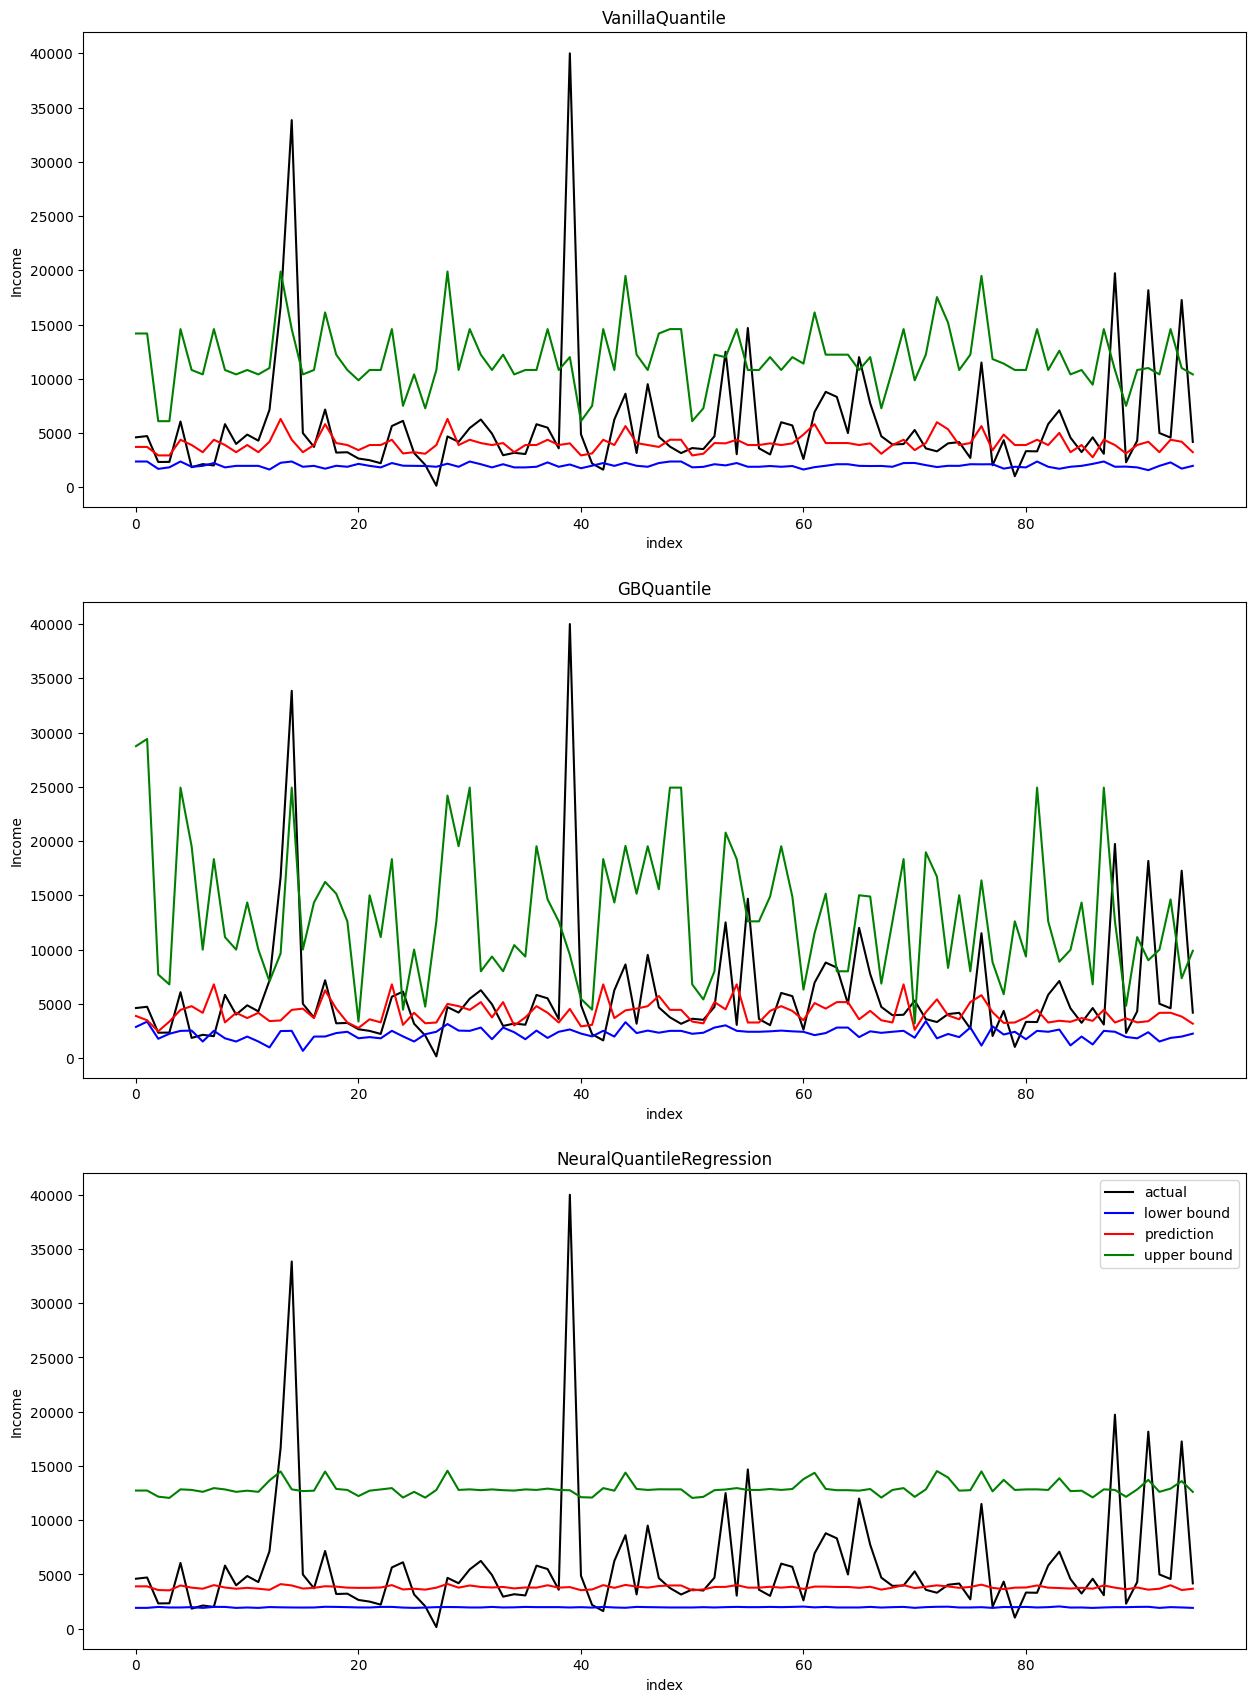

In [16]:
fig, ax = plt.subplots(figsize=(15, 21), nrows=3)

preds = [pred1, pred2, pred3]
names = ["VanillaQuantile", "GBQuantile", "NeuralQuantileRegression"]

for i, (pred, name) in enumerate(zip(preds, names)):
    _ = ax[i].plot(test_encoded["ApplicantIncome"], c="black", label="actual")
    _ = ax[i].plot(pred[:, 0], c="b", label="lower bound")
    _ = ax[i].plot(pred[:, 1], c="red", label="prediction")
    _ = ax[i].plot(pred[:, 2], c="green", label="upper bound")
    _ = ax[i].set_title(name)
    _ = ax[i].set_ylabel("Income")
    _ = ax[i].set_xlabel("index")

_ = plt.legend()

In [17]:
for name, pred in zip(names, preds):
    print(f"{name}:", ((test_encoded["ApplicantIncome"] >= pred[:, 0]) & (test_encoded["ApplicantIncome"] <= pred[:, 2])).mean())

VanillaQuantile: 0.8541666666666666
GBQuantile: 0.8020833333333334
NeuralQuantileRegression: 0.8854166666666666


We experiment 3 different methods for quantile regression, and the results shows that neural quantile regression achieve 88% accuracy, while 86% for vanilla quantile regression and 85% for gradient boosting. The accuracy in this case is the percentage of the actual prediction is in predicted bound.

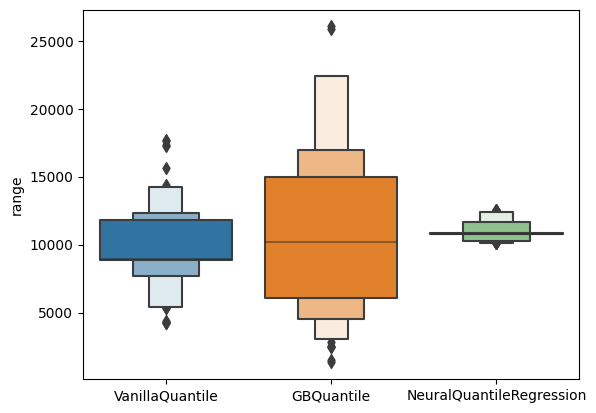

In [18]:
ps = []

for pred, name in zip(preds, names):
    p = (pred[:, 2] - pred[:, 0]).reshape((-1, 1))
    ps.append(p)

ps = pd.DataFrame(np.concatenate(ps, axis=1), columns=names)

_ = sns.boxenplot(ps, )
_ = plt.ylabel("range")

Above figure shows the different range distribution of the models. You can see that the range of the `GBQuantile` model is widely distributed.

Let's see the accuracy a bit deeper.

In [19]:
def drill_down_accuracy(pred: np.ndarray, min_range: int = 0, max_range: int = 20_000, step_size: int = 2_500):
    res = []
    
    r = np.arange(min_range, max_range, step_size)
    for lower, upper in zip(r, r[1:]):
        
        range_ = pred[:, 2] - pred[:, 0]
        
        tmp = test_encoded.copy()
        tmp["range"] = range_
        tmp["lower_bound"] = pred[:, 0]
        tmp["upper_bound"] = pred[:, 2]
        
        tt = tmp[
            (tmp["range"] <= upper) &
            (tmp["range"] >= lower)
        ]
        
        acc = (
            (tt["ApplicantIncome"] >= tt["lower_bound"]) & 
            (tt["ApplicantIncome"] <= tt["upper_bound"])
        ).mean()
        
        res.append([f"[{lower}, {upper}]", acc, tt.shape[0]])
        
    return safe_df(res, ["range", "acc", "n"]).fillna(0)

In [20]:
t = pd.DataFrame(np.concatenate(
    [drill_down_accuracy(preds[0])[["range"]]] + [drill_down_accuracy(pred)[["acc"]] for pred in preds], axis=1
), columns=["range"] + names).melt(["range"])

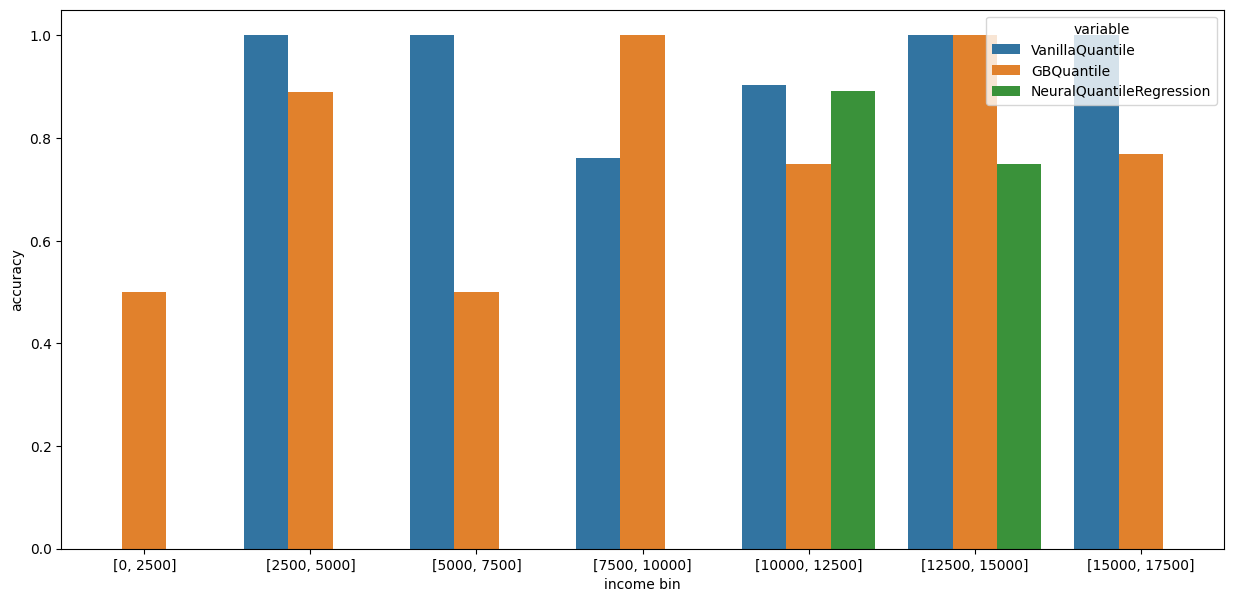

In [21]:
fig, ax = plt.subplots(figsize=(15, 7))

_ = sns.barplot(x="range", hue="variable", y="value", data=t, ax=ax)
_ = ax.set_ylabel("accuracy")
_ = ax.set_xlabel("income bin")

Figure above shows the accuracy in the different predicted bins. `NeuralQuantileRegression` model has the highest accuracy in terms of the global average. However, it only achieves this accuracy in two specific ranges: [10000, 12500] and [12500, 15000]. This might be a result of overfitting, where the model is too closely matching the training data and is not generalizing well to new, unseen data. In contrast, `VanillaQuantile` model performs well across a broad range of predicted income ranges, showing a strong ability to generalize to new data. In order to improve the overall performance, we can use an ensemble technique that combines the strengths of different models and compensates for their weaknesses.

## Conformal prediction

Conformal prediction [[2]]() is a method for generating prediction sets. It allows for the construction of prediction sets that meet the following criteria:

$$
1 - \alpha \le \mathbb{P}(Y_{test} \in C(X_{test})) \le 1 - \alpha + \frac{1}{n+1}
$$

where:

$\alpha$ is the error rate

$C(X_{test})$ is the prediction set

There are three steps to using this method:

* Obtain the score $s$, where higher scores indicate worse agreement between $x$ and $y$.
* Determine the quantile of the score, $\hat{q}$.
* Form the prediction set $C(X_{test}) = {y: s(X_{test}, y) \le \hat{q}}$.

In addition, Conformal prediction can calibrate the predicted outcome for the regression problem. In this case, we would like to calibrate the lower and upper bound of the predicted outcome as the fitted quantile might be inaccurate.

* Define $s$ as $\max\{{\hat{t}_{\alpha/2} - y, y - \hat{t}_{1-\alpha/2}\}}$. Where, $\hat{t}_{\alpha/2}$ is a predicted lower bound at $\alpha$ percentile.
* Define $C(X_{test}) = [\hat{t}_{\alpha/2} - \hat{q}, \hat{t}_{1-\alpha/2} + \hat{q}]$

**Conformal prediction**

In [22]:
def get_qhat(val: pd.DataFrame, model, alpha: float = 0.05) -> float:
    n = val.shape[0]
    
    val_pred = model.predict(val.drop("ApplicantIncome", axis=1), False)
    scores = np.maximum(val_pred[:, 0] - val["ApplicantIncome"].values, val["ApplicantIncome"].values - val_pred[:, 2])
    q_level = np.ceil((n+1) * (1-alpha)) / n
    qhat = np.quantile(scores, q_level, method="higher")
    
    return qhat

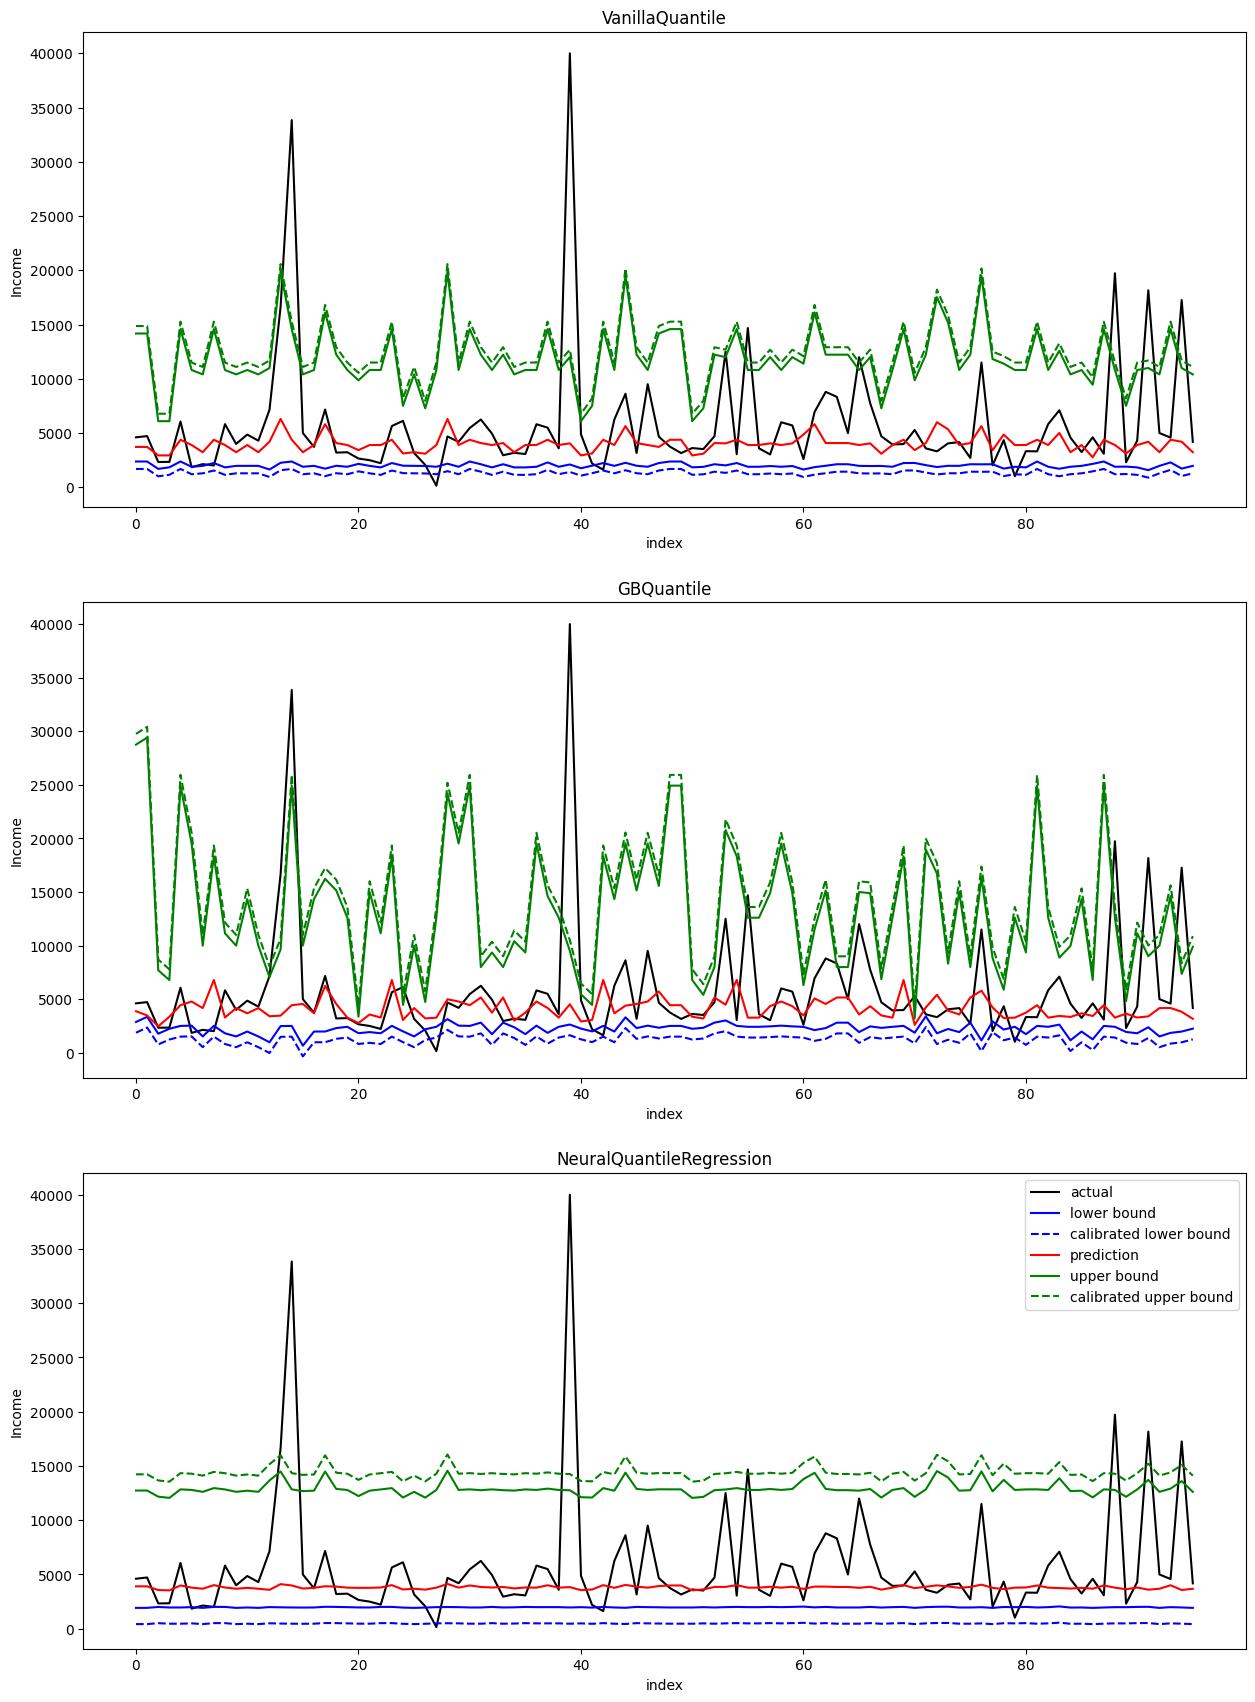

In [23]:
fig, ax = plt.subplots(figsize=(15, 21), nrows=3)

preds = [pred1, pred2, pred3]
names = ["VanillaQuantile", "GBQuantile", "NeuralQuantileRegression"]
qhats = [get_qhat(val_encoded, model, 0.07) for model in [model1, model2, model3]]

for i, (pred, name, qhat) in enumerate(zip(preds, names, qhats)):
    _ = ax[i].plot(test_encoded["ApplicantIncome"], c="black", label="actual")
    _ = ax[i].plot(pred[:, 0], c="b", label="lower bound")
    _ = ax[i].plot(pred[:, 0] - qhat, "--", c="b", label="calibrated lower bound")
    _ = ax[i].plot(pred[:, 1], c="red", label="prediction")
    _ = ax[i].plot(pred[:, 2], c="green", label="upper bound")
    _ = ax[i].plot(pred[:, 2] + qhat, "--", c="green", label="calibrated upper bound")
    _ = ax[i].set_title(name)
    _ = ax[i].set_ylabel("Income")
    _ = ax[i].set_xlabel("index")

_ = plt.legend()

In [24]:
print("---Before calibration---")

for name, pred, qhat in zip(names, preds, qhats):
    print(f"{name}:", ((test_encoded["ApplicantIncome"] >= pred[:, 0]) & (test_encoded["ApplicantIncome"] <= pred[:, 2])).mean())

print("---After calibration---")

for name, pred, qhat in zip(names, preds, qhats):
    print(f"{name}:", ((test_encoded["ApplicantIncome"] >= pred[:, 0] - qhat) & (test_encoded["ApplicantIncome"] <= pred[:, 2] + qhat)).mean())

---Before calibration---
VanillaQuantile: 0.8541666666666666
GBQuantile: 0.8020833333333334
NeuralQuantileRegression: 0.8854166666666666
---After calibration---
VanillaQuantile: 0.90625
GBQuantile: 0.8854166666666666
NeuralQuantileRegression: 0.9166666666666666


This shows that calibrating the lower and upper bound improves the accuracy of the model.

## Using proxy income in loan approval model

It's time to see the performance if we apply all techniques that we have explored in this notebook.

### Training a baseline

Firstly, let's build the baseline model and see the baseline score.

In [25]:
from catboost import CatBoostClassifier

In [26]:
train, test = train_test_split(df_copy, test_size=0.2, random_state=123)
train, val = train_test_split(train, test_size=0.2, random_state=123)

train.shape, val.shape, test.shape

((307, 19), (77, 19), (96, 19))

In [27]:
train_encoded, encoder = encode_all(
    df=train, 
    cat_encoder_fn=encode_categorical_features, 
    num_encoder_fn=encode_numerical_features,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "ApplicantIncome"
    ],
    target="Loan_Status"
)

test_encoded = apply_encoders(
    df=test,
    encoder=encoder,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "ApplicantIncome"
    ],
    target="Loan_Status"
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [28]:
loan_model = CatBoostClassifier(iterations=1e3, depth=5, verbose=0)
_ = loan_model.fit(
    train_encoded.drop("Loan_Status", axis=1), 
    train_encoded["Loan_Status"]
)

In [29]:
test.reset_index(drop=True, inplace=True)

test["pred"] = loan_model.predict(test_encoded.drop("Loan_Status", axis=1))

In [30]:
(test["pred"] == test["Loan_Status"]).mean()

0.7395833333333334

### Training a proxy income model

Now, we will train the proxy income model using quantile regression.

In [31]:
train_income_encoded, income_encoder = encode_all(
    df=train, 
    cat_encoder_fn=encode_categorical_features, 
    num_encoder_fn=encode_numerical_features,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncome"
)

val_income_encoded = apply_encoders(
    df=val,
    encoder=income_encoder,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncome"
)

test_income_encoded = apply_encoders(
    df=test,
    encoder=income_encoder,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncome"
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [32]:
income_model = VanillaQuantileRegression()
_ = income_model.fit(
    train_income_encoded.drop("ApplicantIncome", axis=1), 
    train_income_encoded["ApplicantIncome"]
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:295: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 4: Numerical difficulties encountered.
Result message of linprog:
The solution do

#### Add the predicted income into the dataset.

In [33]:
# For training set
pred = income_model.predict(train_income_encoded.drop("ApplicantIncome", axis=1), False)

qhat = get_qhat(val_income_encoded, income_model, 0.05)

pred[:, 0] -= qhat
pred[:, 2] += qhat

train[["lb_proxy_income", "med_proxy_income", "ub_proxy_income"]] = pred


# For testing set
pred = income_model.predict(test_income_encoded.drop("ApplicantIncome", axis=1), False)

qhat = get_qhat(val_income_encoded, income_model, 0.05)

pred[:, 0] -= qhat
pred[:, 2] += qhat

test[["lb_proxy_income", "med_proxy_income", "ub_proxy_income"]] = pred

### Training a loan approval with proxy income as a feature (point estimation)

Instead of using the actual income, we use the income from the proxy income model.

In [34]:
train_encoded, encoder = encode_all(
    df=train, 
    cat_encoder_fn=encode_categorical_features, 
    num_encoder_fn=encode_numerical_features,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "med_proxy_income"
    ],
    target="Loan_Status"
)

test_encoded = apply_encoders(
    df=test,
    encoder=encoder,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "med_proxy_income"
    ],
    target="Loan_Status"
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [35]:
loan_model = CatBoostClassifier(iterations=1e3, depth=5, verbose=0)
_ = loan_model.fit(
    train_encoded.drop("Loan_Status", axis=1), 
    train_encoded["Loan_Status"]
)

In [36]:
test.reset_index(drop=True, inplace=True)

test["pred"] = loan_model.predict(test_encoded.drop("Loan_Status", axis=1))

In [37]:
(test["pred"] == test["Loan_Status"]).mean()

0.7604166666666666

This is interesting! just using the proxy income as a feature (`med_proxy_income`) instead of the actual one, it improves the performance by ~2%. You might wonder why predicted income is better than the actual income. Our hypothesis is the predicted income is much more smoother than the actual income.

### Training a loan approval with proxy income as a feature (with calibration)

Now, let's include `lb_proxy_income`, `med_proxy_income`, `ub_proxy_income` in the model.

In [38]:
train_encoded, encoder = encode_all(
    df=train, 
    cat_encoder_fn=encode_categorical_features, 
    num_encoder_fn=encode_numerical_features,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "lb_proxy_income", "med_proxy_income", "ub_proxy_income"
    ],
    target="Loan_Status"
)

test_encoded = apply_encoders(
    df=test,
    encoder=encoder,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "lb_proxy_income", "med_proxy_income", "ub_proxy_income"
    ],
    target="Loan_Status"
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/nutorbi

In [39]:
loan_model = CatBoostClassifier(iterations=1e3, depth=5, verbose=0)
_ = loan_model.fit(
    train_encoded.drop("Loan_Status", axis=1), 
    train_encoded["Loan_Status"]
)

In [40]:
test.reset_index(drop=True, inplace=True)

test["pred"] = loan_model.predict(test_encoded.drop("Loan_Status", axis=1))

In [41]:
(test["pred"] == test["Loan_Status"]).mean()

0.78125

It goes up even better with 5% improvement from the baseline.

# References

1. [Quantile regression](https://en.wikipedia.org/wiki/Quantile_regression)
2. [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://arxiv.org/abs/2107.07511)